# softmax从0到1实操**(很重要)

## 前序准备

In [1]:
import torch as tor
from IPython import display as IP_disp
from d2l import torch as d2l_tor

batch_size = 256
train_iter, test_iter = d2l_tor.load_data_fashion_mnist(batch_size)

这里是导入数据，也就是我们还是采用了fashion-mnist这个库来进行实验

In [3]:
num_inputs = 784 # 28 x 28
num_outputs = 10 # 手写数字0-9共十个数字

W = tor.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = tor.zeros(num_outputs, requires_grad=True)
'''
这里进行一下分析,就是我们的图像是28x28的图像,注意我们在这里并没有做多个域的相关,所以可以暂时不考虑点位置
这里我们可以看到就是我们的每个像素点都有一个权重,并且由于是黑白所以没有设置3通道
这里的num_outputs是设置的一个10组的操作(数字0~9)
注意这里的b是只是设置了10组,这就是对于b的需求我们并不会那么大,就直接每组做一个操作罢了
'''

'\n这里进行一下分析,就是我们的图像是28x28的图像,注意我们在这里并没有做多个域的相关,所以可以暂时不考虑点位置\n这里我们可以看到就是我们的每个像素点都有一个权重,并且由于是黑白所以没有设置3通道\n这里的num_outputs是设置的一个10组的操作(数字0~9)\n注意这里的b是只是设置了10组,这就是对于b的需求我们并不会那么大,就直接每组做一个操作罢了\n'

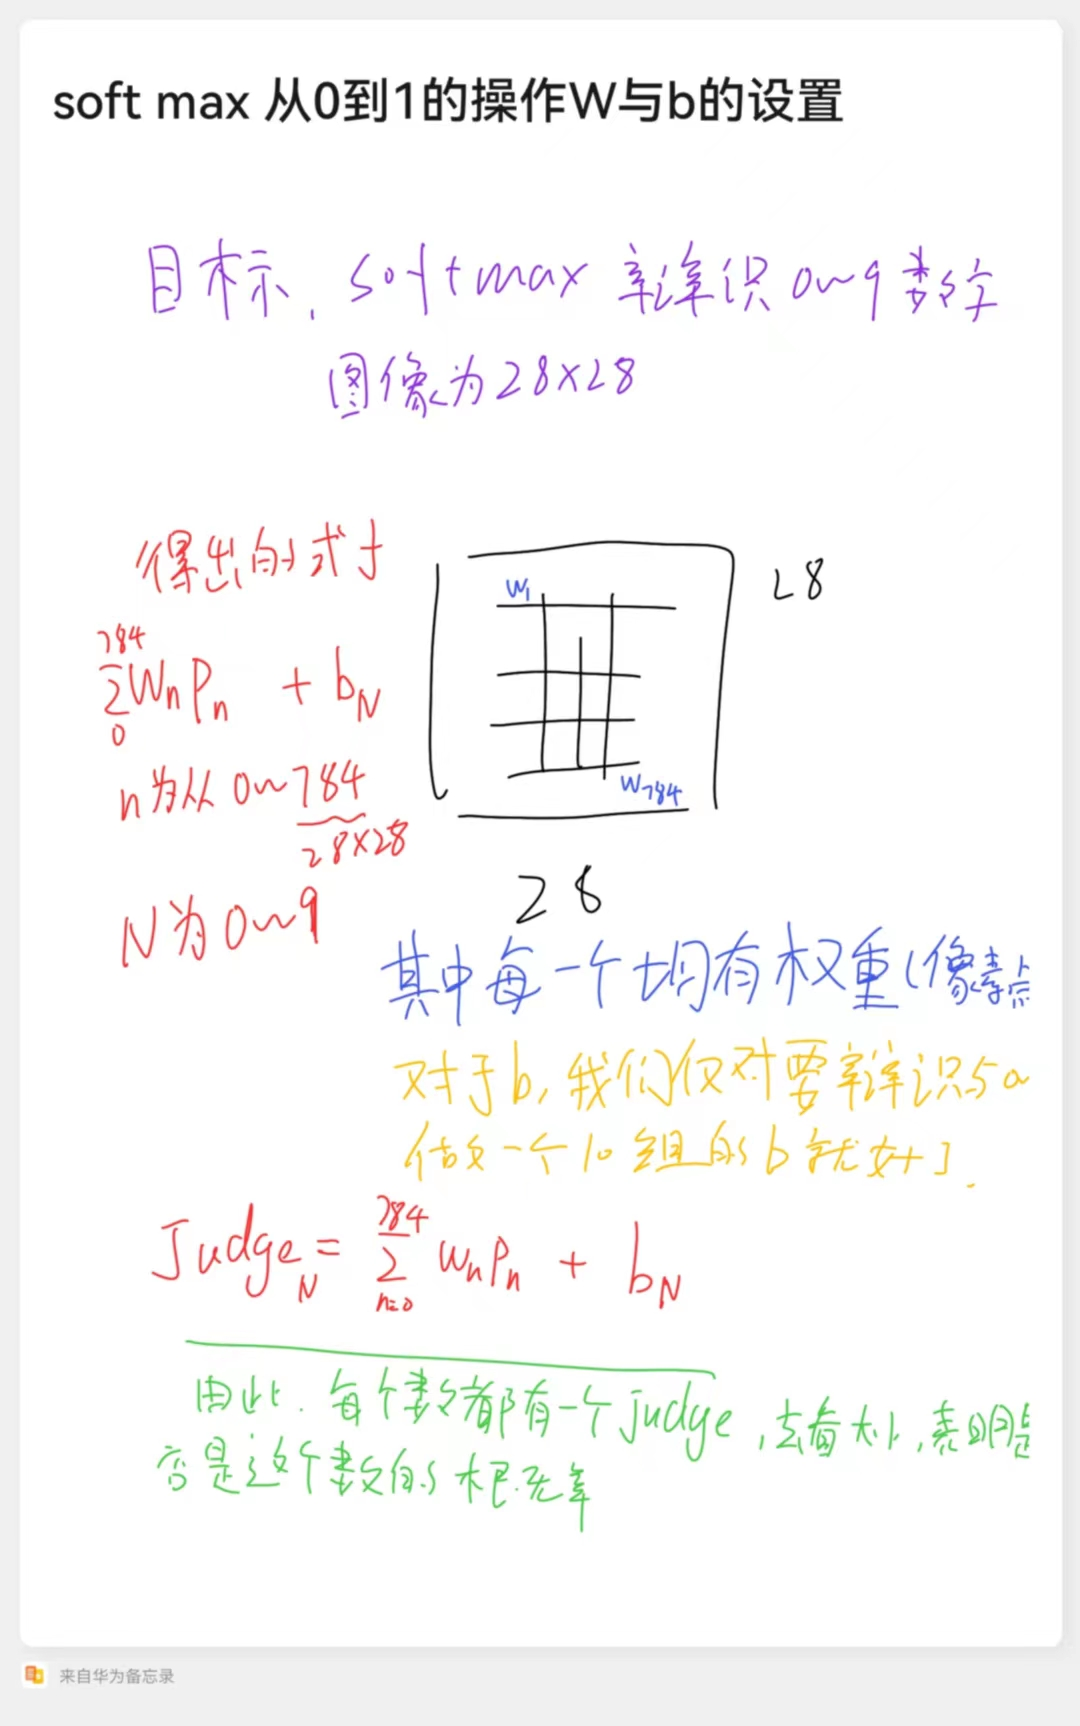

## 实现softmax

$$softmax(X)_{ij} = \frac{e^{X_{ij}}}{\sum_ke^{X_{ik}}}

In [4]:
def softmax(X):
    X_exp = tor.exp(X)
    partition = X_exp.sum(1, keepdim=True) # 这个是为了做数据对齐哦，方柏霓后面广播机制
    return X_exp / partition # 这里应用了广播机制

验证

In [5]:
X= tor.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1), X

(tensor([[0.2212, 0.1131, 0.4332, 0.2066, 0.0258],
         [0.0570, 0.2035, 0.0915, 0.4177, 0.2303]]),
 tensor([1.0000, 1.0000]),
 tensor([[ 0.3947, -0.2766,  1.0668,  0.3265, -1.7524],
         [-1.2927, -0.0202, -0.8199,  0.6987,  0.1035]]))

### 实现加权的softmax

In [6]:
def net(X):
    return softmax(tor.matmul(X.reshape((-1, W.shape[0])), W) + b)

注意这里这个-1是直接如丧数据自行计算自己的排法(相当于batch_size)

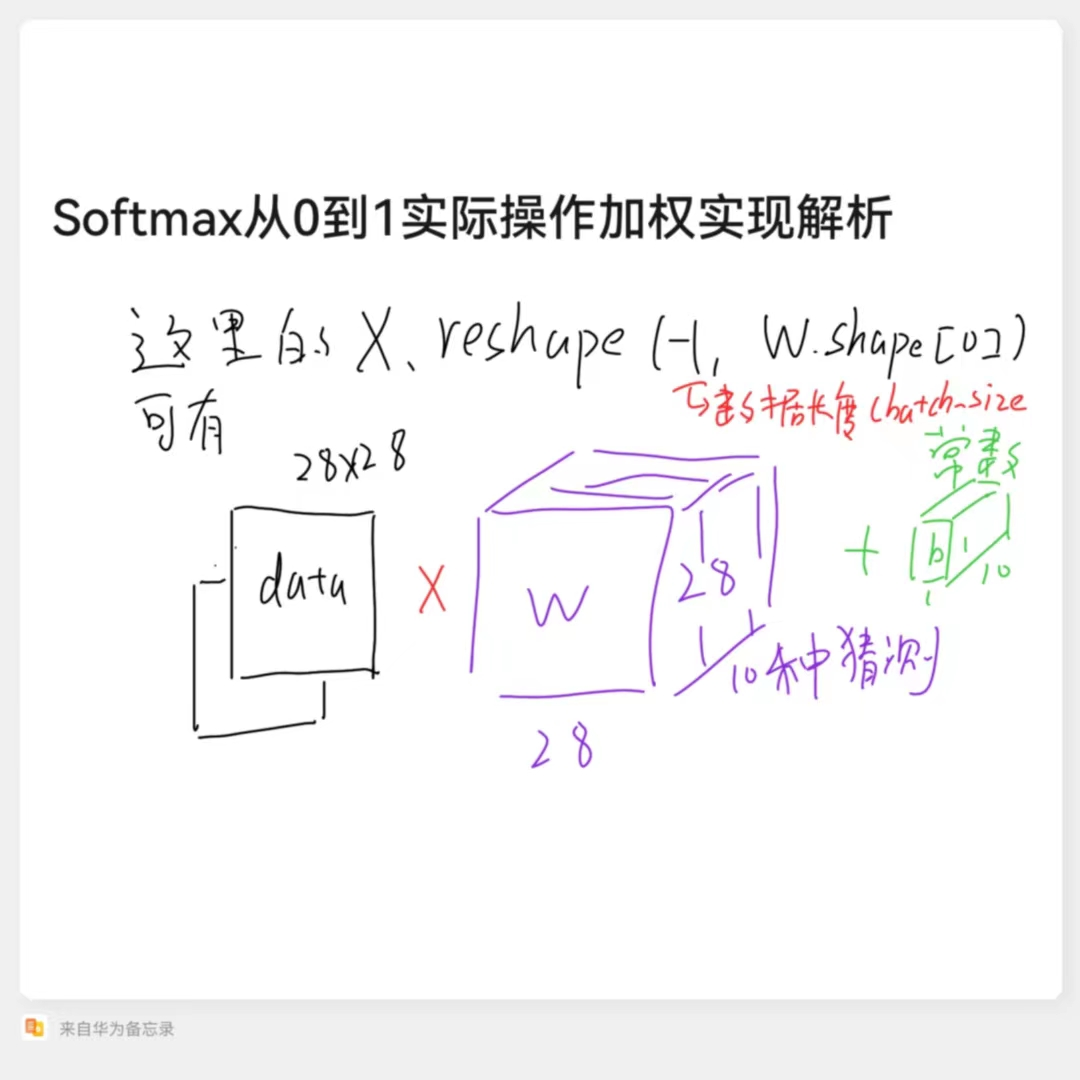

### 交叉熵

$$ H(p,Q) = - \sum_{i}P(i)logQ_i $$

我们可以发现一个有趣的事实，我们可以知道$P(i)$是表示正确的概率状况,$Q(i)$是表示观察到的概率状况,在我们的标准中,对于一个完全正确的预测,我们所看到的就是$P(i)$在正确时为1,其余状态下为0!这就产生了一个有趣的事实:我们其实只要计算$logQ_i(i = right)$于是就有了下列式子

#### torch索引查找规则

In [7]:
y = tor.tensor([0, 2])
y_hat = tor.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y], len(y_hat) # 其实就是展示一个索引查找验证罢了

(tensor([0.1000, 0.5000]), 2)

#### 实现交叉熵损失函数

In [8]:
def cross_entropy(y_hat, y):
    return -tor.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

上述程序就是一个log

将预测类别与真实y元素进行比较

In [9]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 找出最大值，最大值就是当前系数中表达的那个手写符号
    cmp = y_hat.type(y.dtype) == y # 转换为同样类型
    return float(cmp.type(y.dtype).sum()) # 正确数求和

accuracy(y_hat, y) / len(y) # 平均比较

0.5

In [10]:
class Accumulator:
    """在'n'个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        """就是想省个循环"""
    def reset(self):
        self.data = [0.0] * len(self.data) # 归零
    
    def __getitem__(self, idx):
        return self.data[idx] # 取值

In [11]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上的精度(训好模型看效果)"""
    if isinstance(net, tor.nn.Module):
        net.eval() # 如果模型是torch的模型，那么就将其设置为评估模式用来评估效果
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [12]:
evaluate_accuracy(net, test_iter)

0.0832

这里这个net就是一个随机的net(X)中的赋值，其实就是我们完全没有W的值，所以这边对于模型整体的聘雇就是0.1也就是10个数字乱猜

## 训练

In [13]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型的一轮"""
    # 如果这是个torch的模型,需要将他设置为训练模式
    if isinstance(net, tor.nn.Module):
        net.train() # torch需要设置训练模式
    # 训练损失总和、训练精确度总和、样本数
    metric = Accumulator(3) # 设置三个比较块
    for X, y in train_iter:
        # 计算梯度并跟新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, tor.optim.Optimizer): # 自带的优化器
            # 使用PyTorch内置优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 自定义的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练和损失精度
    return metric[0] / metric[2], metric[1] / metric[2]

接下来，展示的是一个绘画作图的一个操作

In [15]:
class Animator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l_tor.use_svg_display()
        self.fig, self.axes = d2l_tor.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l_tor.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # display.display(self.fig)
        # display.clear_output(wait=True)

接下来就是关于我们自己的这个训练函数，也就是说我们将使用自己的训练方法，对应于前面的训练框架的使用，首先这个是一个整体的设置就是全信息的设置

In [19]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print("train_loss:")
    print(train_loss)
    print("train_acc:")
    print(train_acc)
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc # 这个是设置展示区间

那当然，我们的updater也将是自己实现，我们采用随机梯度下降进行优化，学习率为0.1

In [20]:
lr = 0.1

def updater(batch_size):
    return d2l_tor.sgd([W, b], lr, batch_size)

ok,现在我们训练10轮，这是个超参数

train_loss:
0.44729101956685385
train_acc:
0.8482166666666666


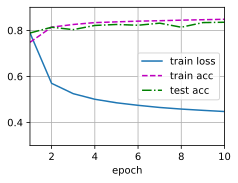

In [21]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

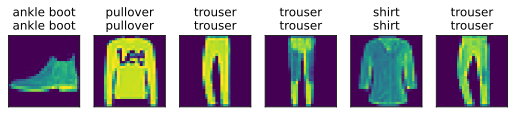

In [22]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l_tor.get_fashion_mnist_labels(y)
    preds = d2l_tor.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l_tor.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

这个其实就是将寻出来的数据结合代码操作一波罢了